In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sb
from scipy.stats import kurtosis, skew, spearmanr
from scipy.linalg import norm, lstsq
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor

In [9]:
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = lstsq(C[:, idx], C[:, j])[0]
            beta_j = lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2062588229.py:15: UserWarning: set_ticklabels() should only be 

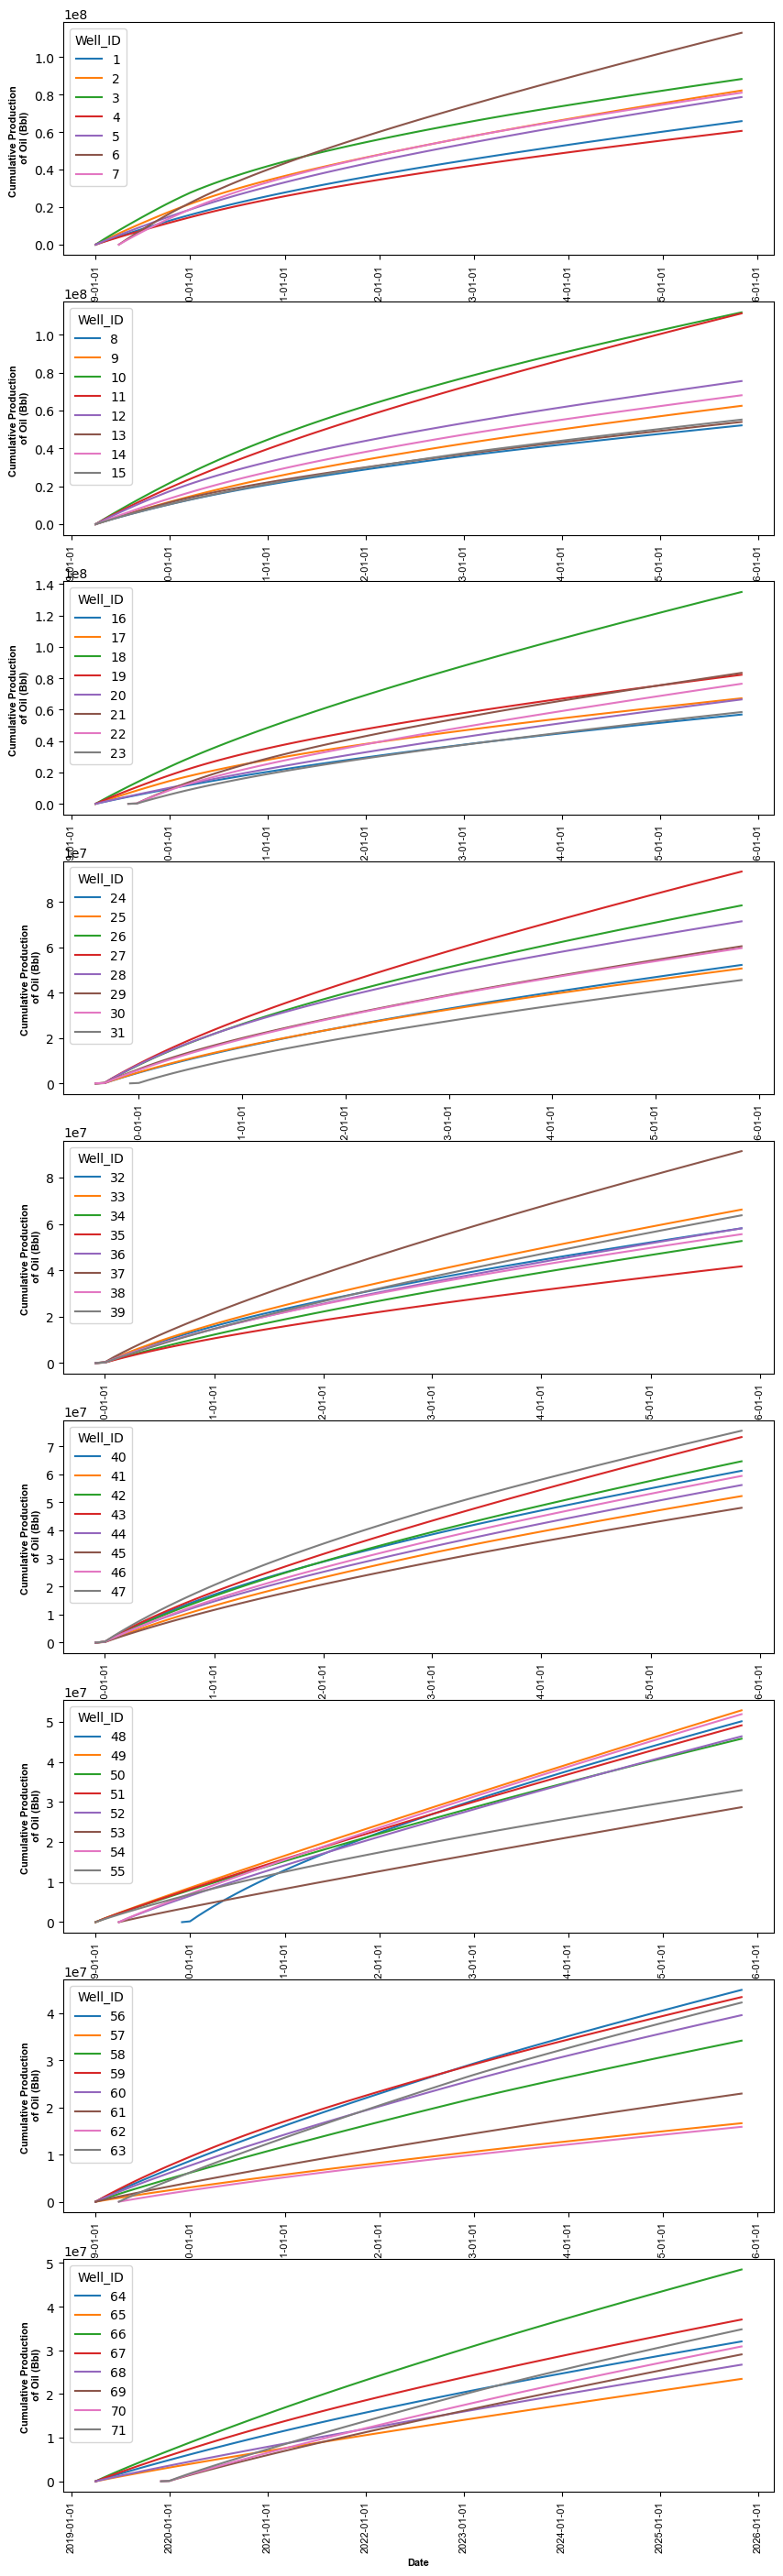

In [10]:


df = pd.read_csv( "production.csv",parse_dates=["Date"] )
fig,ax = plt.subplots( 9,1,figsize=(10,35) )




for i in range(9):
    wellidx     = i*8
    sb.lineplot( data=df[(df["Well_ID"]>=wellidx) & (df["Well_ID"]<=wellidx+7)], x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax[i] )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [11]:
np.unique( df["Well_ID"] )

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71], dtype=int64)

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2628011662.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


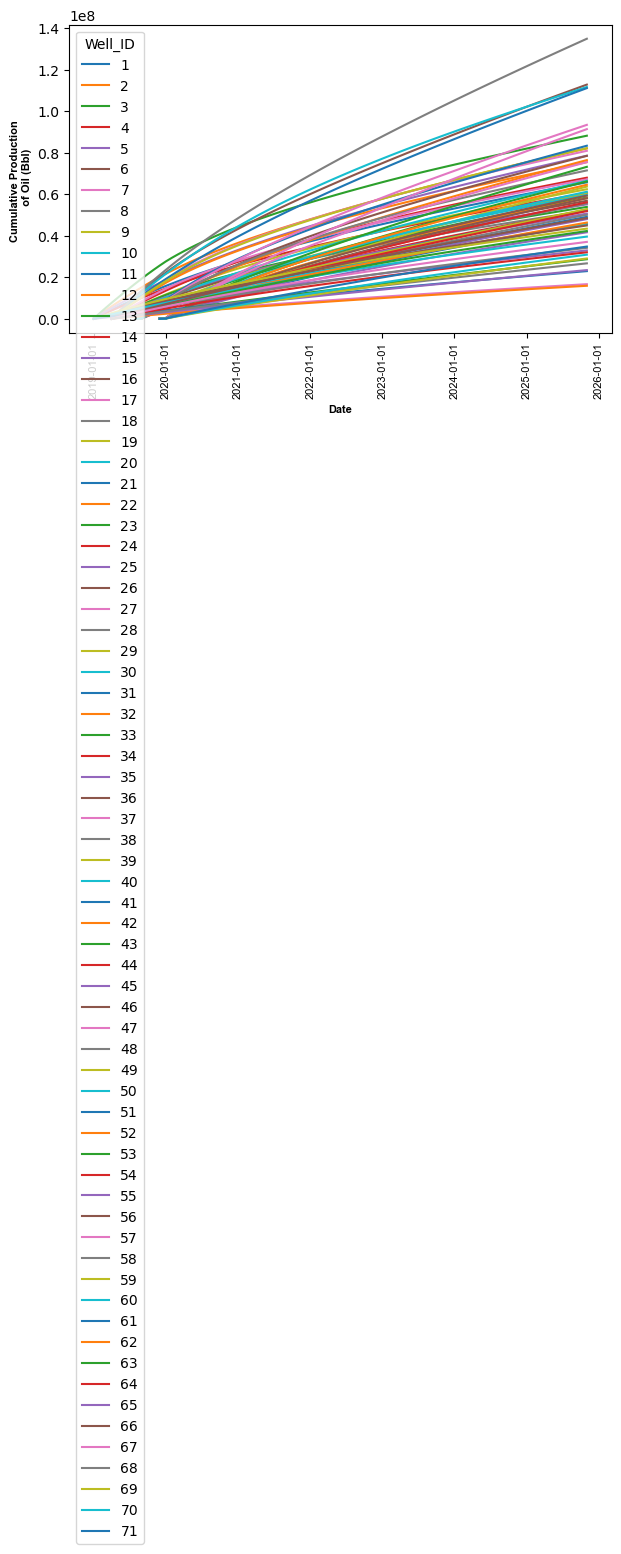

In [12]:
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=df, x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [13]:
dflogs = pd.read_csv( "logs.csv" )
 
df["gamma_var"] = 0
df["gamma_skew"] = 0
df["months"] = 0
df["mean_por"] = 0
df["mean_perm"] = 0
df["kurt_perm"] = 0
df["neighbor_density_25"] = 0
df["neighbor_density_70"] = 0
df["X"] = 0
df["Y"] = 0
df["cumulative_3y"] = 0
df["gamma_mean"] = 0
df["facies_p75"] = 0
df["z_mean"] = 0
df["acoustic_imp"] = 0
df["kophi_sqrt_of_means"] = 0
df["kophi_mean_of_sqrts"] = 0

def calculate_well_density( xvals,yvals,allx,ally,allIDs,quantile ):
    x   = xvals[0]
    y   = yvals[0]
    ids = np.unique( allIDs )
    dists = [  ]
    for id in ids:
        idxs=np.argwhere( allIDs==id )
        xs  = allx[idxs][0]
        ys  = ally[idxs][0]
        if x!=xs and y!=ys:
            dists.append( 1/norm( np.array([x-xs,y-ys]) ) )
    return np.min( dists )

for id in np.unique(dflogs["Well_ID"]):
    df.loc[df["Well_ID"]==id,"X"] = np.unique( dflogs[dflogs["Well_ID"]==id]["X"] )[0]
    df.loc[df["Well_ID"]==id,"Y"] = np.unique( dflogs[dflogs["Well_ID"]==id]["Y"] )[0]
    df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
    df.loc[df["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
    df.loc[df["Well_ID"]==id,"kophi_mean_of_sqrts"] = ( np.mean( np.sqrt(dflogs[dflogs["Well_ID"]==id]["perm"]/dflogs[dflogs["Well_ID"]==id]["phi"] ) ) )
    df.loc[df["Well_ID"]==id,"z_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["Z"] )
    df.loc[df["Well_ID"]==id,"gamma_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["GR"] )
    df.loc[df["Well_ID"]==id,"facies_p75"] = np.quantile( dflogs[dflogs["Well_ID"]==id]["facies"],0.75 )
    df.loc[df["Well_ID"]==id,"gamma_skew"] = skew( dflogs[dflogs["Well_ID"]==id]["GR"].values )
    df.loc[df["Well_ID"]==id,"mean_por"] = np.mean( dflogs[dflogs["Well_ID"]==id]["phi"] )
    df.loc[df["Well_ID"]==id,"mean_perm"] = np.mean( dflogs[dflogs["Well_ID"]==id]["perm"] )
    df.loc[df["Well_ID"]==id,"kurt_perm"] = kurtosis( dflogs[dflogs["Well_ID"]==id]["perm"].values )
    df.loc[df["Well_ID"]==id,"neighbor_density_25"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.25 )
    df.loc[df["Well_ID"]==id,"neighbor_density_70"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.7 )
    df.loc[df["Well_ID"] == id, "months"] = (
        df.loc[df["Well_ID"] == id, "Date"]
        - df.loc[df["Well_ID"] == id, "Date"].min(  )
    ).dt.days
    monthsWell          = df[df["Well_ID"]==id]["months"] - 36
    prodWell          = df[df["Well_ID"]==id]["Cumulative Oil Production, BBL"]
    df.loc[df["Well_ID"]==id,"cumulative_3y"] = np.min( prodWell[monthsWell>0] )
    
df["months"]=df["months"]/30

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\571528975.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.61655934299265' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
C:\Users\chris\AppData\Local\Temp\ipykernel_7560\571528975.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5096851.315789473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
C:\Users\chris\AppData\Local\Temp\ipykernel_7560\571528975.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.70295417296884' has 

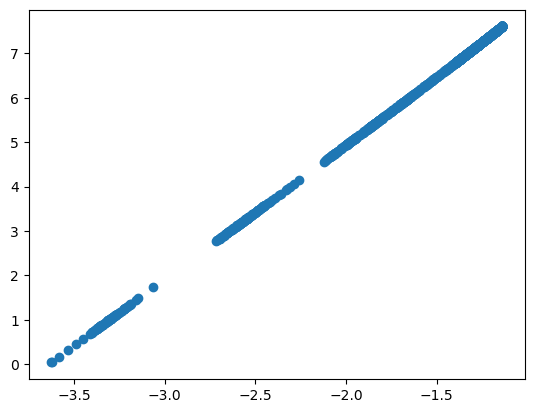

In [14]:
plt.scatter( np.log( dflogs["phi"] ),np.log(dflogs["perm"]) )

In [15]:
df

,Well_ID,Date,"Cumulative Gas Production, ft3","Cumulative Oil Production, BBL","Cumulative Water Production, BBL",gamma_var,gamma_skew,months,mean_por,mean_perm,...,neighbor_density_70,X,Y,cumulative_3y,gamma_mean,facies_p75,z_mean,acoustic_imp,kophi_sqrt_of_means,kophi_mean_of_sqrts
0,1,2019-01-01,0.000000e+00,0.00,0.000000e+00,12.616559,NaN,0.000000,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
1,1,2019-02-01,1.981249e+09,1560038.50,4.634771e+04,12.616559,NaN,1.033333,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
2,1,2019-03-01,3.661006e+09,2882681.25,8.738335e+04,12.616559,NaN,1.966667,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
3,1,2019-04-01,5.474707e+09,4310793.00,1.334990e+05,12.616559,NaN,3.000000,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
4,1,2019-05-01,7.194637e+09,5665069.00,1.791346e+05,12.616559,NaN,4.000000,0.225434,884.329315,...,0.005692,33,127,2882681.25,34.50313,NaN,29,5.096851e+06,0,54.702954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,71,2025-07-01,4.209285e+10,33143974.00,2.761039e+06,27.173784,0.225046,67.966667,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698
5513,71,2025-08-01,4.262622e+10,33563956.00,2.809077e+06,27.173784,0.225046,69.000000,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698
5514,71,2025-09-01,4.315820e+10,33982832.00,2.857320e+06,27.173784,0.225046,70.033333,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698
5515,71,2025-10-01,4.367173e+10,34387188.00,2.904204e+06,27.173784,0.225046,71.033333,0.176152,429.657251,...,0.005708,151,166,812823.00,58.07322,5.0,29,6.083808e+06,0,42.329698


In [16]:
dflogs

,Well_ID,X,Y,Z,AI,SI,Vp,Vs,rho_b,rho_f,...,Kdry,Kf,Ksat,G0,Gdry,Gsat,facies,phi,perm,GR
0,1,33,127,19,5943276.00,NaN,2509.036133,1090.884644,2.368749,1.031188,...,3.545598,2.053309,11.153387,22.357136,2.818880,2.818880,4.0,0.168519,270.908982,64.492799
1,1,33,127,20,5919975.00,2565816.00,2501.055908,NaN,2.366990,1.031302,...,3.522153,2.054320,11.097732,22.127697,2.781343,NaN,4.0,0.169546,275.991820,59.381030
2,1,33,127,21,5964042.00,2626229.75,2520.884766,1110.056396,2.365853,1.031283,...,NaN,2.054156,11.147645,23.269091,2.915263,2.915263,4.0,0.170632,281.433205,58.695883
3,1,33,127,22,7214826.00,3753484.00,2968.669678,1544.438354,2.430323,1.015337,...,5.419065,1.922070,13.689069,33.429173,5.797025,5.797025,3.0,0.131763,128.040537,39.931218
4,1,33,127,23,7219024.00,3770280.75,2972.544189,NaN,2.428567,1.015382,...,5.423145,1.922422,13.654531,33.858128,5.853251,5.853251,3.0,0.132931,NaN,37.518093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,71,151,166,35,4095578.25,1889011.00,1893.622070,873.398743,2.162828,0.922046,...,1.309159,1.396673,5.555665,42.209805,1.649860,1.649860,2.0,0.281013,1325.150121,33.343715
1487,71,151,166,36,4142597.25,1914249.00,1907.745605,881.548462,2.171462,0.922793,...,NaN,1.399736,5.653017,42.189388,1.687503,1.687503,2.0,0.276123,1253.468462,20.888743
1488,71,151,166,37,4189854.00,1941441.25,1921.716187,890.460388,2.180267,0.922656,...,1.368478,1.399171,NaN,42.197090,1.728777,1.728777,2.0,0.270999,1181.391043,25.646714
1489,71,151,166,38,4234563.50,1969158.75,1934.696655,899.673523,2.188748,0.921575,...,1.398950,1.394749,5.830463,NaN,1.771600,1.771600,2.0,0.265927,1113.016864,22.504533


C:\Users\chris\AppData\Local\Temp\ipykernel_7560\1949035277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


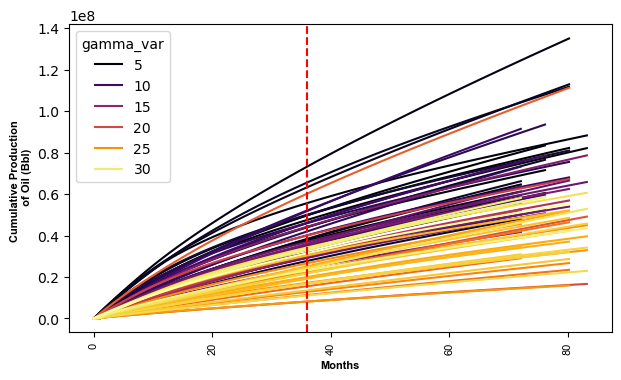

In [17]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_var",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\681984011.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


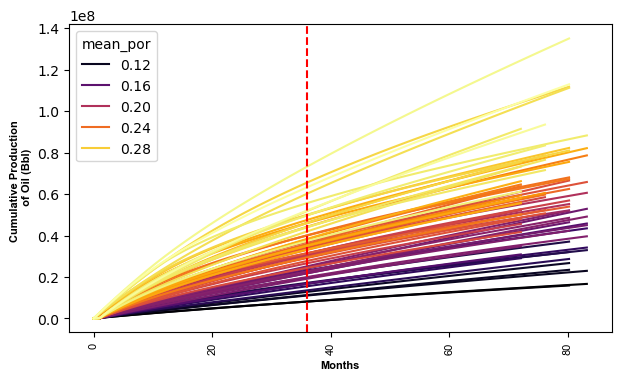

In [18]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_por",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2076334418.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


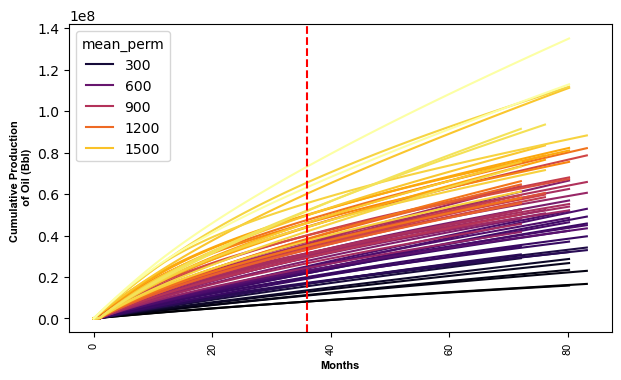

In [19]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_perm",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\1183271054.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


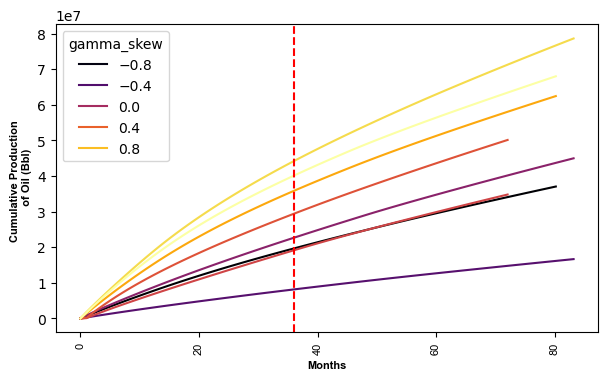

In [20]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_skew",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\1660267431.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


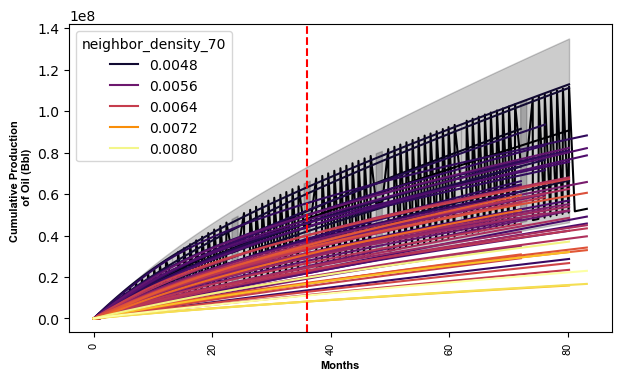

In [21]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="neighbor_density_70",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

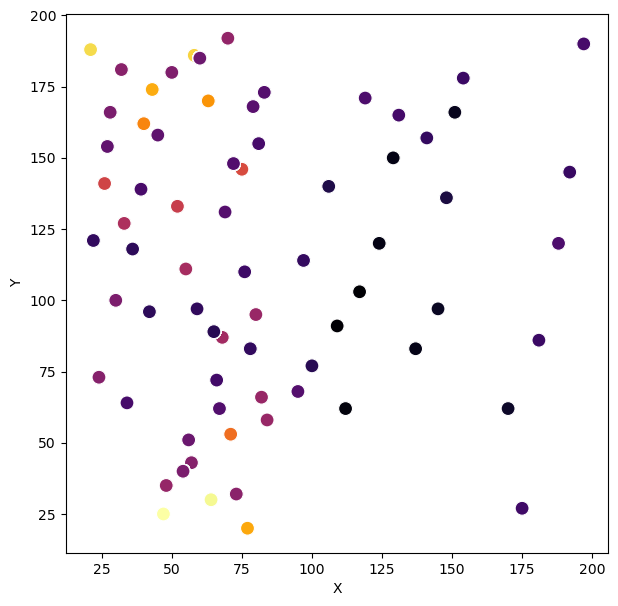

In [22]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="cumulative_3y",palette="inferno",ax=ax,s=100 );
ax.legend().remove()


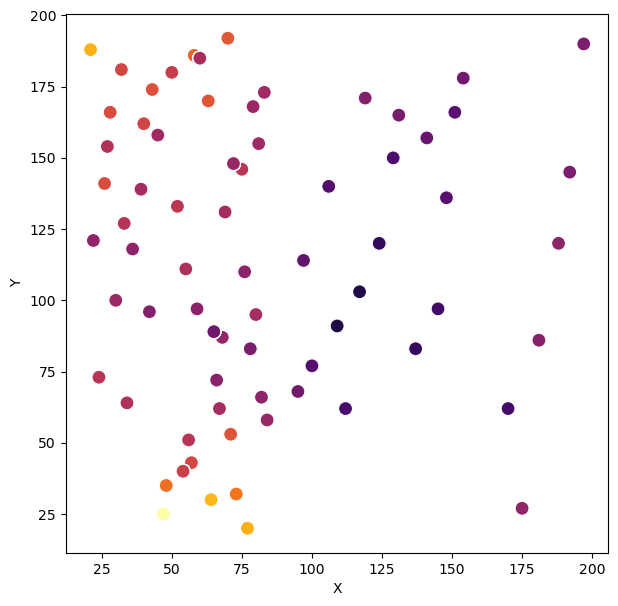

In [23]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

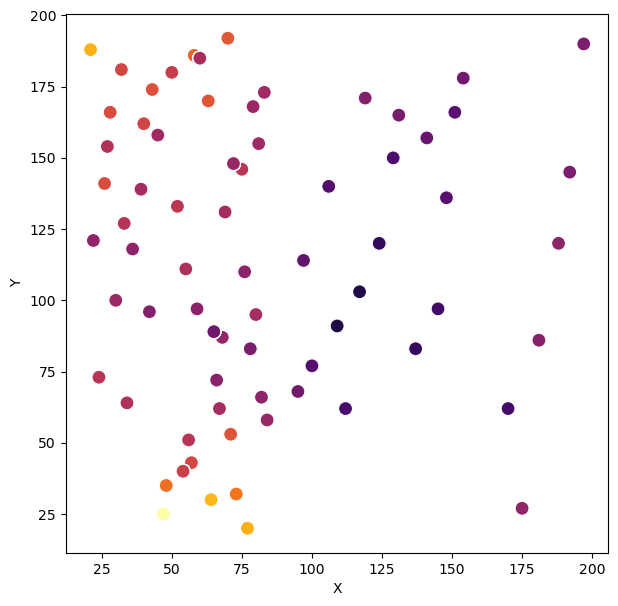

In [36]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

In [37]:
df_out = df.groupby("Well_ID", as_index=False).first(  )

In [68]:
df_out = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","neighbor_density_25","neighbor_density_70","facies_p75","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]

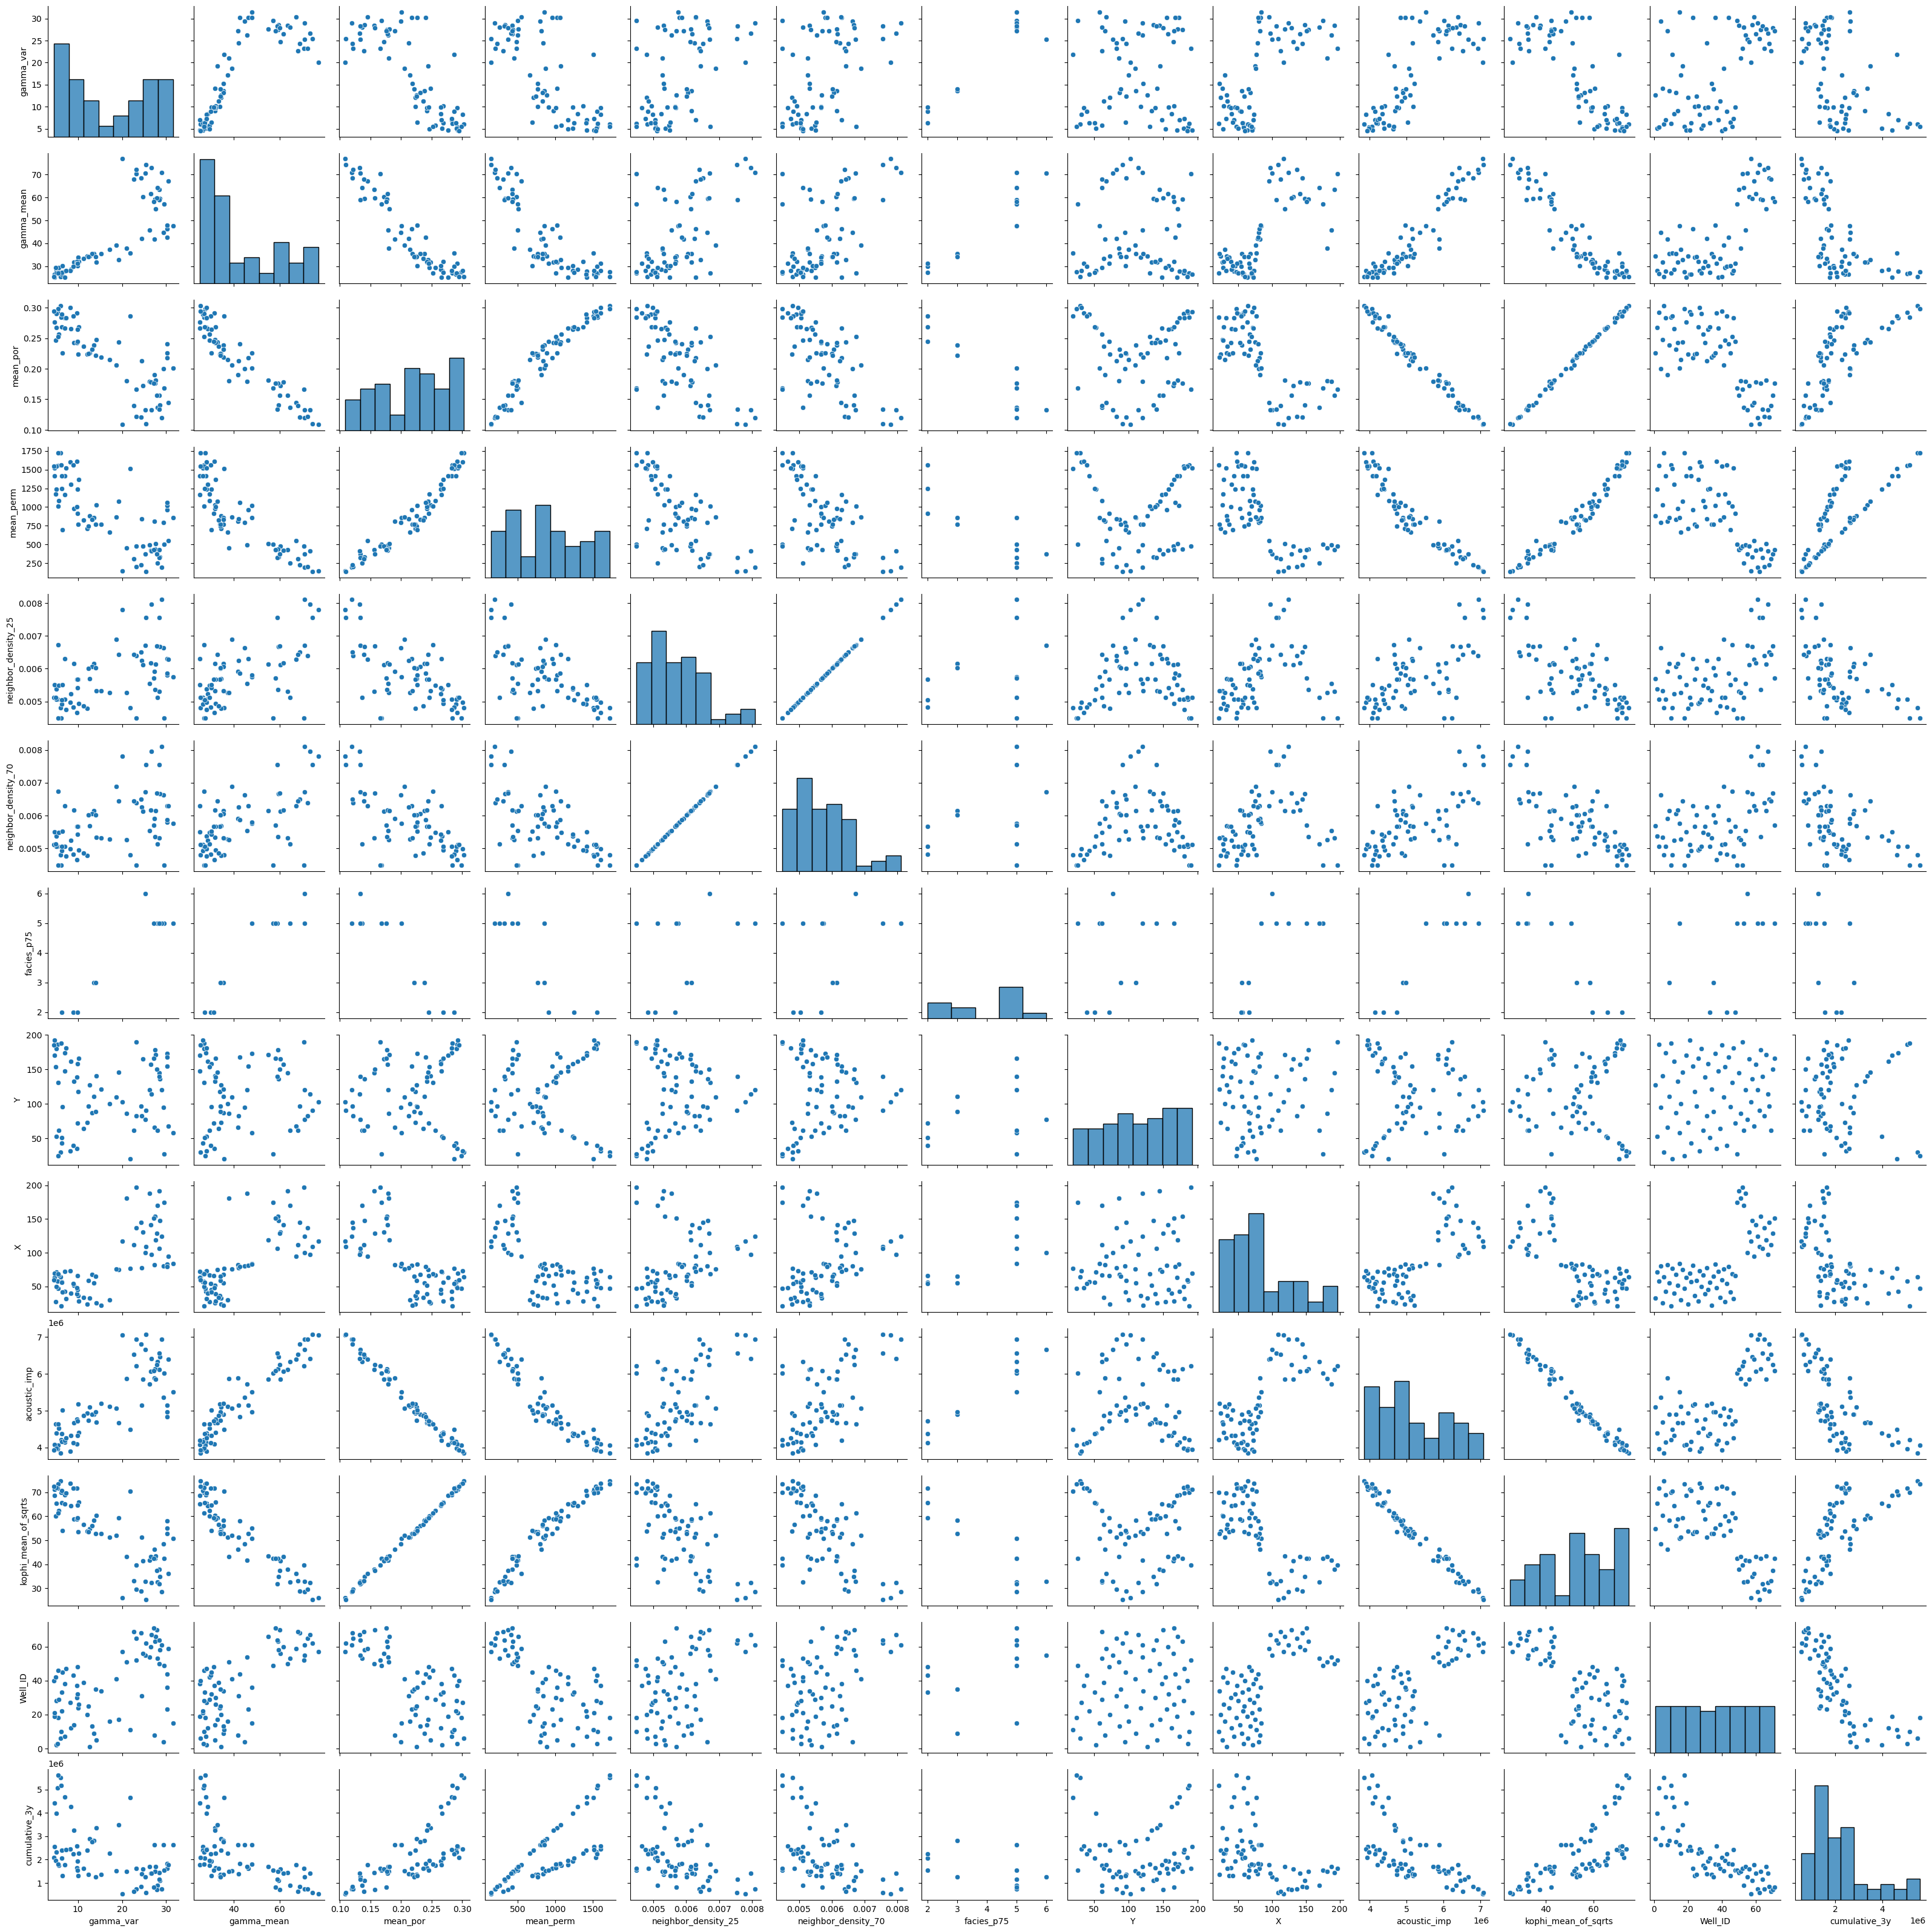

In [71]:
sb.pairplot(df_out)

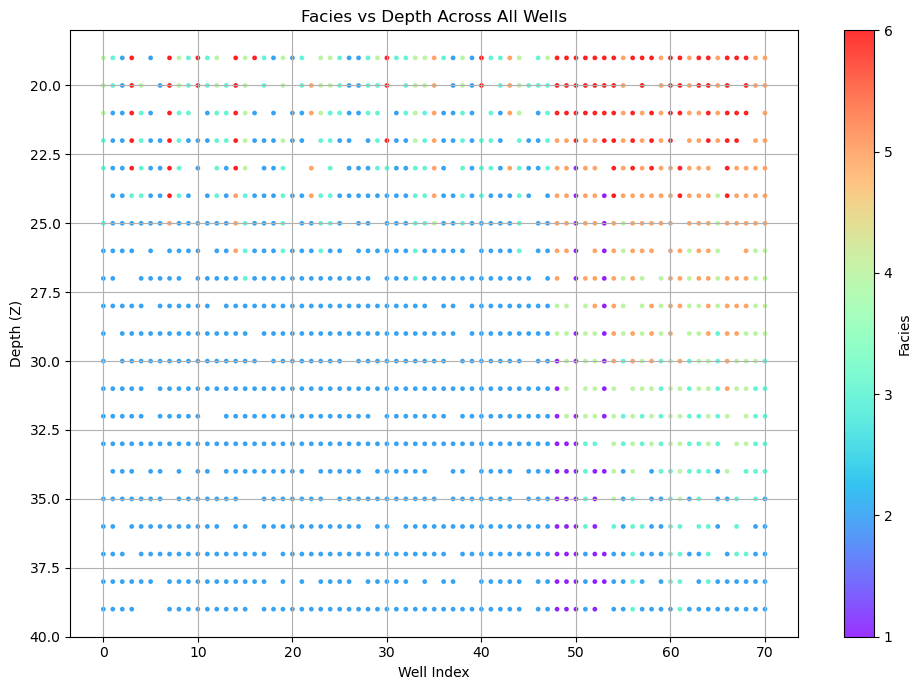

In [99]:
logs = pd.read_csv( "logs.csv" )

# Convert Well_ID to numeric codes for plotting
logs["WellIndex"] = logs["Well_ID"].astype("category").cat.codes

plt.figure(figsize=(10,7))

plt.scatter(
    logs["WellIndex"],
    logs["Z"],
    c=logs["facies"],
    cmap="rainbow",   # <-- smooth inferno gradient
    s=6,
    alpha=0.8
)




plt.xlabel("Well Index")
plt.ylabel("Depth (Z)")
plt.title("Facies vs Depth Across All Wells")
plt.gca().invert_yaxis()
plt.grid(True)

cbar = plt.colorbar()
cbar.set_label("Facies")

plt.tight_layout()
plt.show()


<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

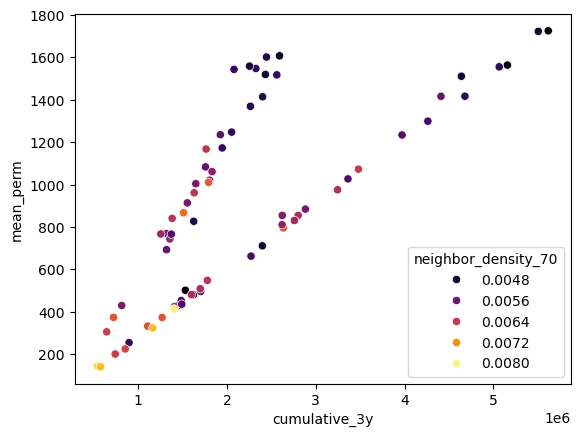

In [ ]:
df_out["is_crowded"] = np.where(df_out["neighbor_density_70"]>0.006,1,0)
# sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_crowded",palette="inferno" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

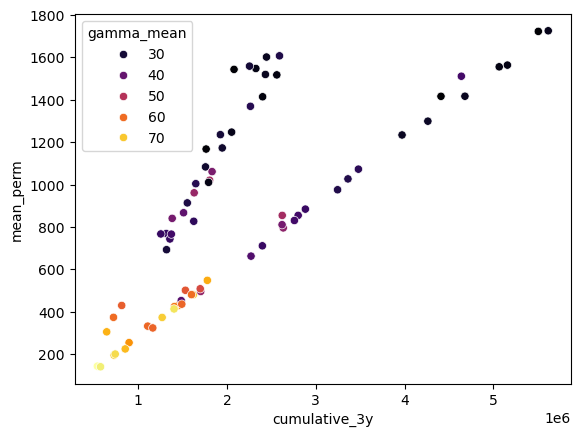

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="gamma_mean",palette="inferno" )

In [ ]:
df_facies = pd.read_csv("facies.csv")
df_out["facies_percentage"] = df_facies["Percentage_Facies_3_or_Less"]

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

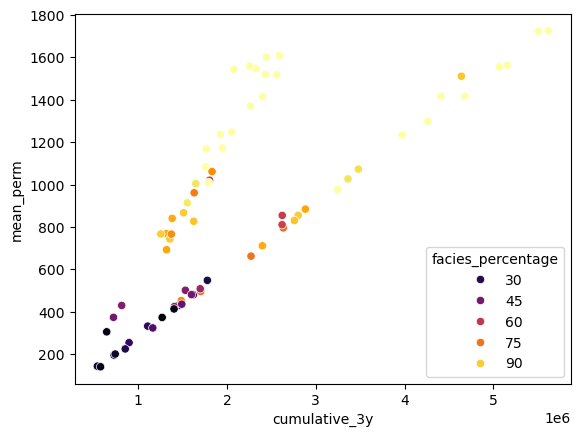

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="facies_percentage",palette="inferno" )

In [ ]:
df_out["y_north"] = np.where( (df_out["X"]<100) & (df_out["Y"]<100),"North","South" )
df_out["x_east"] = np.where( df_out["X"]>=80,"East","West" )
df_out["region"] = np.where( (df_out["X"]<=90) & ((df_out["Y"]<70) | (df_out["Y"]>125)),"in_region","out_region" )
df_out["region_north"] = np.where( (df_out["region"]=="in_region") & (df_out["Y"]<100),"in_region_north","in_region_south" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

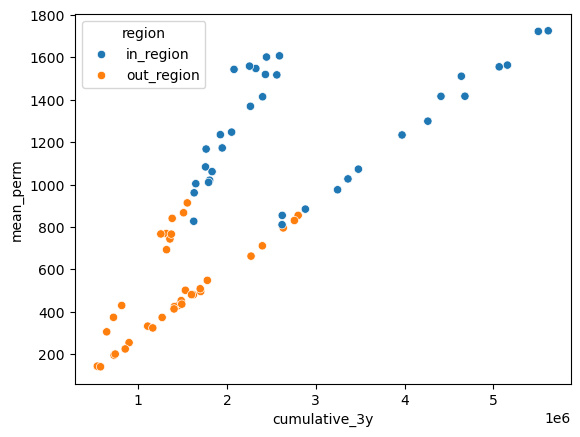

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="region",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

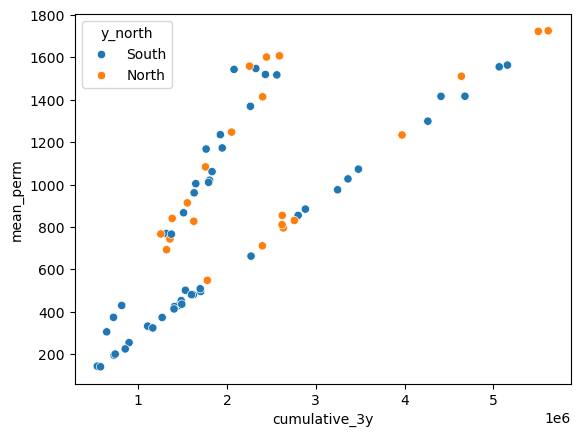

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="y_north",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

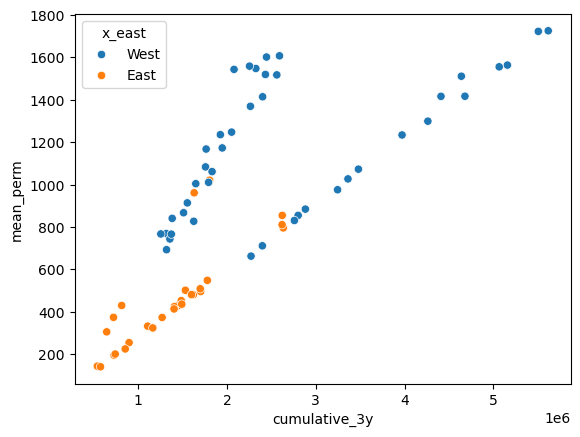

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="x_east",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

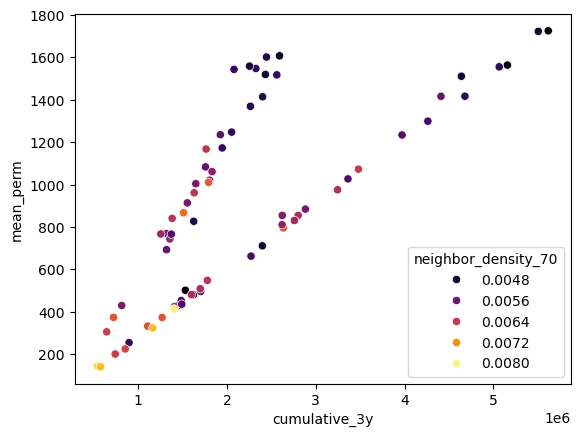

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

In [ ]:
df_mechanical = pd.read_csv( "mechanical.csv" )
df_out["brittleness"] = df_mechanical["Mean_Brittleness_Index"]
df_out["young"] = df_mechanical["Mean_Youngs_Modulus_Velocities"]
df_out["poisson"] = df_mechanical["Mean_Poisson_Ratio_Ksat_Gsat"]

In [ ]:
df_out["is_well_id"] = np.where(df_out["Well_ID"]>50,"fifties","forties")

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

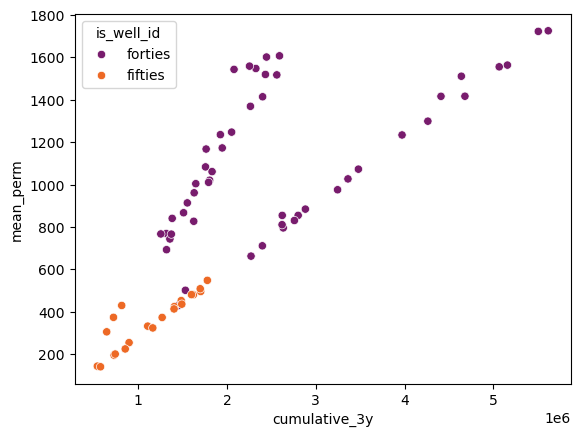

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_well_id",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

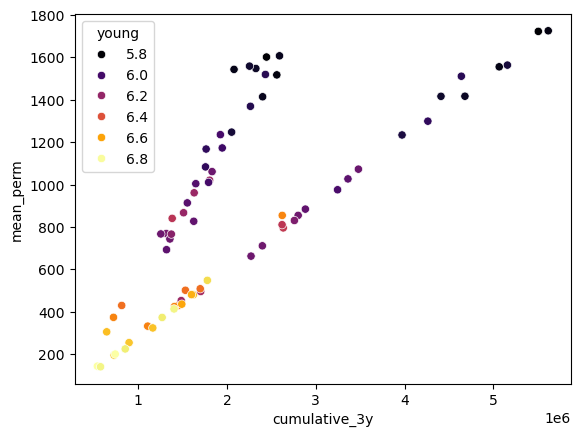

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="young",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

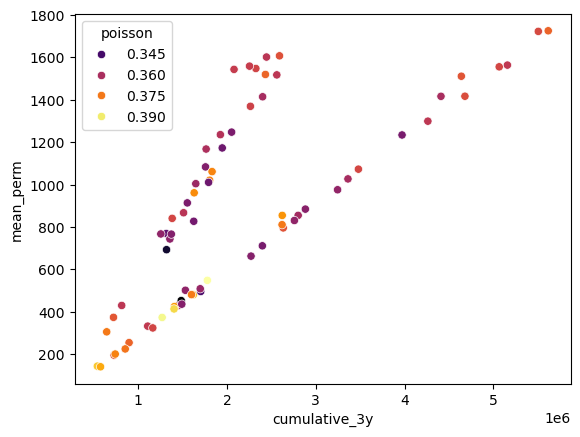

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="poisson",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

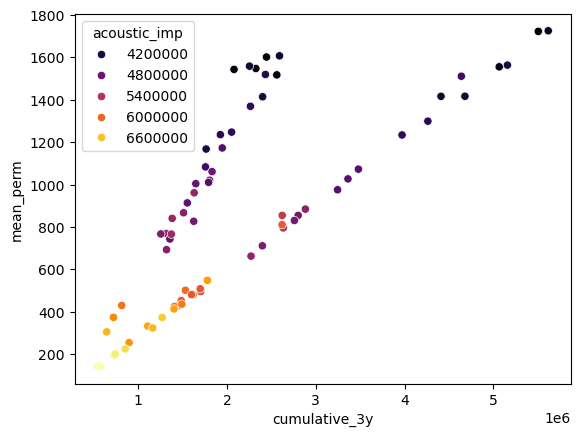

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="acoustic_imp",palette="inferno" )


<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

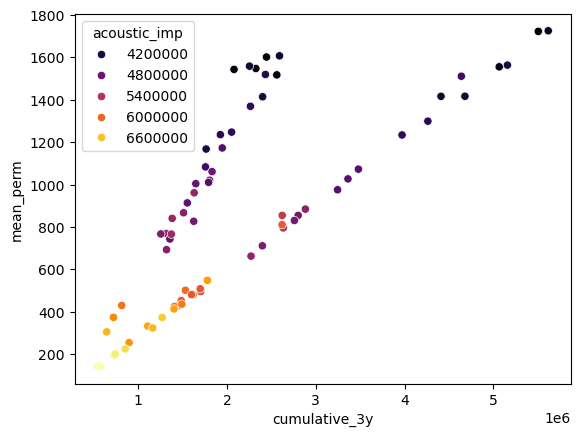

In [ ]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="acoustic_imp",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

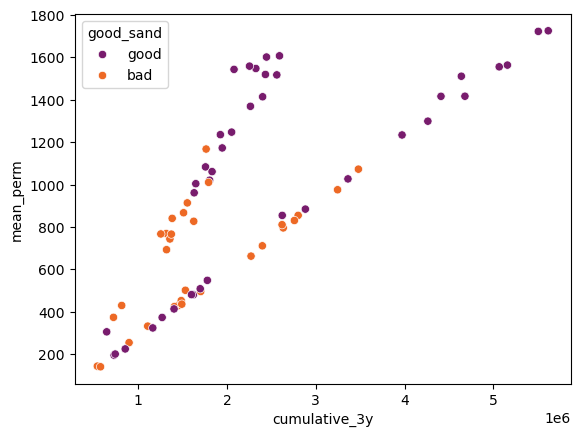

In [ ]:
df_perm_facies = pd.read_csv("perm_facies.csv")
df_out["mean_perm_f2"] = df_perm_facies["facies_2"]
df_out["good_sand"] = np.where( df_perm_facies["facies_2"]>1200,"good","bad" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="good_sand",palette="inferno" )

<Axes: xlabel='mean_perm', ylabel='cumulative_3y'>

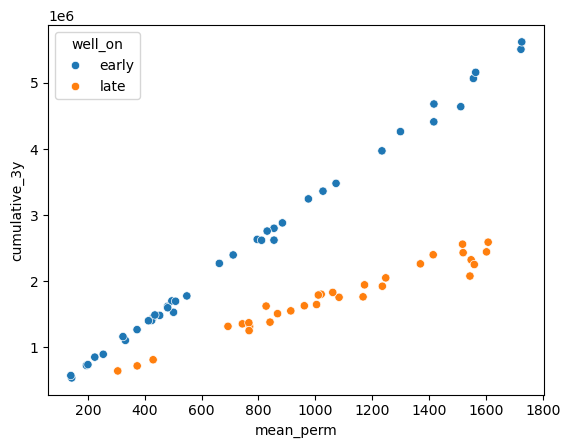

In [ ]:
df_times = pd.read_csv( "times.csv",parse_dates=["earliest"] )
df_times["is_before_cutoff_2"] = np.where( df_times["earliest"]<pd.to_datetime( "2019-08-01",format="%Y-%m-%d" ),1,0 )
df_out["well_on"] = np.where(df_times["is_before_cutoff_2"],"early","late")
sb.scatterplot( data=df_out,y="cumulative_3y",x="mean_perm",hue="well_on",palette="tab10" )

## Training Model with Only Late Wells

C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2484556113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
C:\Users\chris\AppData\Local\Temp\ipykernel_7560\2484556113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["logperm"] = np.log( df_train["mean_perm"] )


<Axes: xlabel='logperm', ylabel='cumulative_3y'>

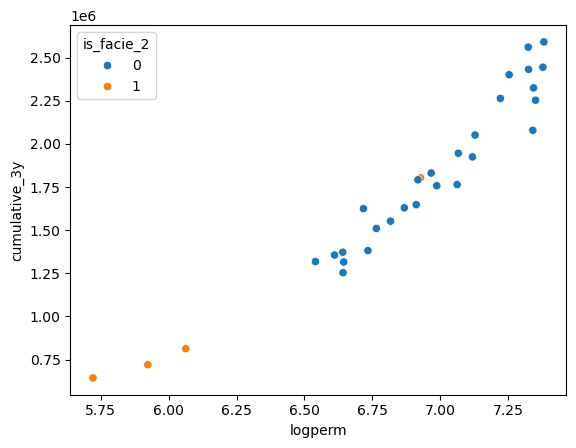

In [ ]:
df_train = df_out[df_out["well_on"]=="late"]
df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
df_train["logperm"] = np.log( df_train["mean_perm"] )
sb.scatterplot( data=df_train,x="logperm",y="cumulative_3y",hue="is_facie_2",palette="tab10" )

c:\Users\chris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+11, tolerance: 5.924e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e+11, tolerance: 7.611e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\chris\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.189e+11, toleranc

BaggingRegressor()

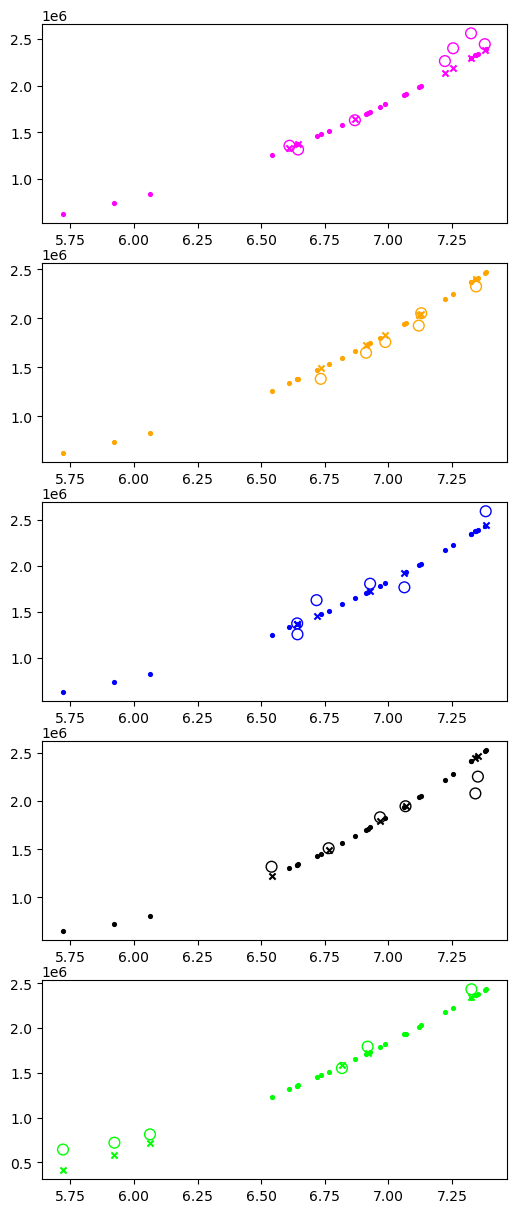

In [ ]:
fig,ax = plt.subplots( 5,1,figsize=(6,15) )

X = df_train["logperm"].values
# X = df_train[["X","Y"]].values
y = df_train["cumulative_3y"].values
kf = KFold(n_splits=5 ,shuffle=False)
r2scores = [  ]
cols = ["magenta","orange","blue","black","lime"]

for i, (train_index, test_index) in enumerate(kf.split(X)):
    poly=PolynomialFeatures(degree=3,include_bias=True)
    

    pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', Lasso(  ))] )
    X_train, X_test, y_train, y_test = X[train_index].reshape(-1,1),X[test_index].reshape(-1,1),y[train_index],y[test_index]
    poly_features=poly.fit_transform(X_train.reshape(-1,1))
    poly_test=poly.transform( X_test.reshape(-1,1) )
    pipe.fit(poly_features, y_train)

    ypred = pipe.predict( poly_test )
    ytrainpreds = pipe.predict( poly_features )  

    # ypred =   pipe.predict( X_test )
    # ytrainpreds = pipe.predict( X_train )

    ax[i].scatter( X_train,ytrainpreds,color=cols[i],lw=1.5,label=f"Fold: {i}",s=5 )
    ax[i].scatter( X_test,ypred,marker="x",s=20,color=cols[i] )
    ax[i].scatter( X_test,y_test,marker="o",s=60,edgecolors=cols[i],facecolors='None' )

    r2scores.append( r2_score( y[test_index],ypred ) )
    # ax[i].legend()
BaggingRegressor(  )

In [ ]:
r2scores

[0.9204474444710542,
 0.9265380452637814,
 0.9153003683792367,
 0.6895344020556051,
 0.9628332644029705]

In [ ]:
r2scores

[0.9204474444710542,
 0.9265380452637814,
 0.9153003683792367,
 0.6895344020556051,
 0.9628332644029705]

### PC

In [ ]:
df_pca = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]
print(f"rows: {df_pca.shape}")
df_pca = df_pca.dropna(  )
print(f"rows: {df_pca.shape}")

rows: (71, 10)
rows: (71, 10)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X = df_pca.iloc[:,:-1]
X_new = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
df_pca["pc1"] = X_new[:,0]
df_pca["pc2"] = X_new[:,1]

[9.99999972e-01 2.37680632e-08 2.78261709e-09 1.16954186e-09
 2.09634613e-10]


<Axes: xlabel='pc1', ylabel='pc2'>

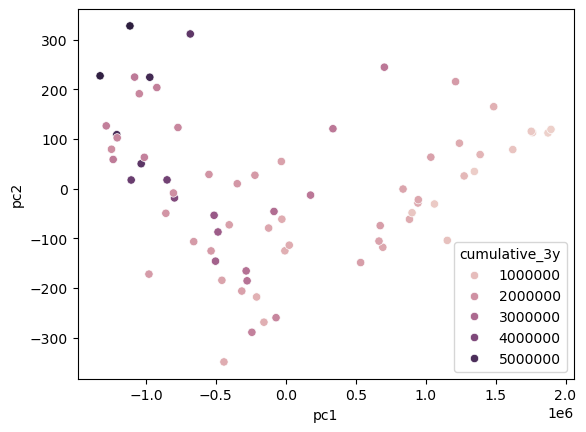

In [ ]:
sb.scatterplot( data=df_pca,x="pc1",y="pc2",hue="cumulative_3y")#acoustic_imp" )

### Model Construction

In [ ]:
# X = df_out[["gamma_var","mean_perm","mean_por"]].values
X = df_out[["X","Y"]].values
y = df_out["cumulative_3y"].values
kf = KFold(n_splits=5)#,shuffle=True)
r2scores = [  ]
for i, (train_index, test_index) in enumerate(kf.split(X)):
    pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', DecisionTreeRegressor(  ))] )
    X_train, X_test, y_train, y_test = X[train_index,:],X[test_index,:],y[train_index],y[test_index]
    pipe.fit(X_train, y_train)
    ypred = pipe.predict( X_test )
    r2scores.append( r2_score( y[test_index],ypred ) )


In [ ]:
r2scores

[-2.736250925156729,
 -0.8050401437330772,
 -20.069000025530517,
 -0.6822099941695066,
 -1.001418428939846]